
# **<center>From: https://learnopencv.com/introduction-to-video-classification-and-human-activity-recognition/</center>**

# **<center>Introduction to Video Classification & Human Activity Recognition</center>**




---



---



**Here are the steps we will perform:**

- **Step 1: Download and Extract the Dataset**
- **Step 2: Visualize the Data with its Labels**
- **Step 3: Read and Preprocess the Dataset**
- **Step 4: Split the Data into Train and Test Set**
- **Step 5: Construct the Model**
- **Step 6: Compile & Train the Model**
- **Step 7: Plot Model’s Loss & Accuracy Curves**
- **Step 8: Make Predictions with the Model**
- **Step 9: Using Single-Frame CNN Method**

#### **Import Required Libraries:**
Start by importing all required libraries.

In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

**Set Numpy, Python & Tensorflow seeds to get consistent results.**

In [3]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **Step 1: Read & Preprocess the Dataset**

Since we're going to use a classification architecture to train on a video classification dataset, we're goiing to need to preprocess the dataset first.

Now w constants, 
- **`image_height`** and **`image_weight`**: This is the size we will resize all frames of the video to, we're doing this to avoid unneccsary computation.

- **`max_images_per_class`**: Maximum number of training images allowed for each class.

- **`dataset_directory`**: The path of the directory containing the extracted dataset. 

- **`classes_list`**: These are the list of classes we're going to be training on, we're traninng on following 4 classes, you can feel free to change it. 
  - *clap*
  - *wave*
  - *mind_blown*

**Note:** The `image_height`, `image_weight` and `max_images_per_class` constants may be increased for better results, but be warned this will become computationally expensive.

In [5]:
image_height, image_width = 64, 64
max_images_per_class = 5000

dataset_directory = "pepper_data"
classes_list = ["clap", "wave", 'mind_blown']

model_output_size = len(classes_list)

### **Extract, Resize & Normalize Frames**


Now we'll create a function that will extract frames from each video while performing other preprocessing operation like resizing and normalizing images. 

This method takes a video file path as input. It then reads the video file frame by frame, resizes each frame, normalizes the resized frame, appends the normalized frame into a list and then finally returns that list.

In [6]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

### **Dataset Creation**
Now we'll create another function called  **`create_dataset()`**,  this function uses the **`frame_extraction()`** funciton above and creates our final preprocessed dataset. 

**Here's how this function works:**

1.   Iterate through all the classes mentioned in the `classes_list`
2.   Now for each class iterate through all the video files present in it. 
3.   Call the **frame_extraction** method on each video file.
4.   Add the returned frames to a list called `temp_features`
5.   After all videos of a class are processed, randomly select video frames (equal to **max_images_per_class**) and add them to the list called `features`.
6.   Add labels of the selected videos to the labels list.
7.   After all videos of all classes are processed then return the features and labels as numpy arrays.


So when you call this function, it returns **2** lists:
- a list of feature vectors 
- a list of it's associated labels.


In [7]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

Calling the **create_dataset** method which returns features and labels.

In [8]:
features, labels = create_dataset()

Extracting Data of Class: clap
Extracting Data of Class: left_hand
Extracting Data of Class: right_hand
Extracting Data of Class: mind_blown


Now we will convert class labels to one hot encoded vectors.

In [9]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

## **Step 2: Split the Data into Train and Test Set**
Now we have 2 numpy arrays, one containing all images, the second one contains all class labels in one hot encoded format. Let’s split our data to create a training and a testing set. It’s important that you shuffle your data before the split which we have already done.


In [10]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, stratify=one_hot_encoded_labels,shuffle = True, random_state = seed_constant)

## **Step 3: Construct the Model**
Now it’s time to create our CNN model, for this post, we're c reating a simple CNN Classification model with two CNN layers.

In [11]:
# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 128)       147584    
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 128)      0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                        

### **Check Model’s Structure:**
Using the **plot_model** function you can check the structure of the final model, this is really helpful when you’re creating a complex network and you want to make sure you have constructed the network correctly.

In [12]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## **Step 4: Compile & Train the Model**


Now let's start the training. Before we do that, we also need to complile the model.


In [13]:
# Adding the Early Stopping Callback to the model which will continuously monitor the validation loss metric for every epoch.
# If the models validation loss does not decrease after 15 consecutive epochs, the training will be stopped and the weight which reported the lowest validation loss will be retored in the model.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
1280/1280 [==============================] - 81s 63ms/step - loss: 1.3965 - accuracy: 0.3449 - val_loss: 4.3066 - val_accuracy: 0.2430
Epoch 2/50
1280/1280 [==============================] - 82s 64ms/step - loss: 1.3173 - accuracy: 0.4080 - val_loss: 8.2207 - val_accuracy: 0.2719
Epoch 3/50
1280/1280 [==============================] - 83s 65ms/step - loss: 1.2537 - accuracy: 0.4354 - val_loss: 8.2595 - val_accuracy: 0.2477
Epoch 4/50
1280/1280 [==============================] - 88s 69ms/step - loss: 1.2441 - accuracy: 0.4529 - val_loss: 8.9609 - val_accuracy: 0.2484
Epoch 5/50
1280/1280 [==============================] - 86s 67ms/step - loss: 1.1675 - accuracy: 0.4943 - val_loss: 3.3316 - val_accuracy: 0.3672
Epoch 6/50
1280/1280 [==============================] - 86s 67ms/step - loss: 1.0858 - accuracy: 0.5400 - val_loss: 2.1531 - val_accuracy: 0.4062
Epoch 7/50
1280/1280 [==============================] - 141s 110ms/step - loss: 0.9735 - accuracy: 0.5934 - val_loss: 1.3959

### **Evaluating Your Trained Model**
Evaluate your trained model on the feature's and label's test sets.

In [23]:
model_evaluation_history = model.evaluate(features_test, labels_test)

Reset css and font defaults in:
/Users/nathansimms/.jupyter/custom &
/Users/nathansimms/Library/Jupyter/nbextensions
50/50 [==============================] - 5s 107ms/step - loss: 0.4984 - accuracy: 0.8700


### **Save Your Model**
You should now save your model for future runs.

In [28]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)

## **Step 5: Plot Model’s Loss & Accuracy Curves**
Let's plot our loss and accuracy curves.

In [25]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

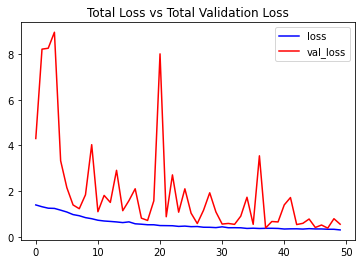

In [26]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

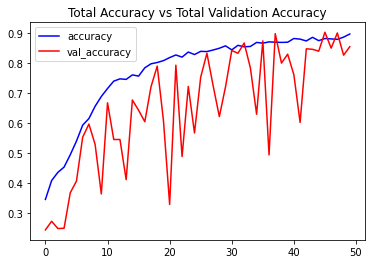

In [27]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## **Step 6: Using Single-Frame CNN Method:**
Now let's create a function that will output a singular prediction for the complete video, now this function will take `n` frames from the entire video and make predictions. In the end, it will average the predictions of those <code>n</code> frames to give you the final activity class for that video. You can set the value of <code>n</code> using the <code>predictions_frames_count</code> variable.

This function is useful when you have a video containing one activity and you want to know the activity's name and its score.


In [ ]:
def make_average_predictions(video_file_path, predictions_frames_count):
    
    # Initializing the Numpy array which will store Prediction Probabilities
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting The Total Frames present in the video 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating The Number of Frames to skip Before reading a frame
    skip_frames_window = video_frames_count // predictions_frames_count

    for frame_counter in range(predictions_frames_count): 

        # Setting Frame Position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading The Frame
        _ , frame = video_reader.read() 

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities

    # Calculating Average of Predicted Labels Probabilities Column Wise 
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Sorting the Averaged Predicted Labels Probabilities
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]

    # Iterating Over All Averaged Predicted Label Probabilities
    for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:

        # Accessing The Class Name using predicted label.
        predicted_class_name = classes_list[predicted_label]

        # Accessing The Averaged Probability using predicted label.
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label]

        print(f"CLASS NAME: {predicted_class_name}   AVERAGED PROBABILITY: {(predicted_probability*100):.2}")
    
    # Closing the VideoCapture Object and releasing all resources held by it. 
    video_reader.release()